In [59]:
# %matplotlib inline

import sys
import h5py
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from matplotlib import pyplot as plt
from pathlib import Path

In [60]:
# !pip install git+https://github.com/Gaskell-1206/fastMRI.git@Shengjia/Annotation
sys.path.append('../../')
import fastmri
from fastmri.data import transforms as T 

In [61]:
file_path = Path('/Users/gaskell/Dropbox/Mac/Desktop/fastMRI/fastmriplus_test/multicoil_train')
file_list = list(file_path.glob('**/*.h5'))
file_list

[PosixPath('/Users/gaskell/Dropbox/Mac/Desktop/fastMRI/fastmriplus_test/multicoil_train/file1000306.h5'),
 PosixPath('/Users/gaskell/Dropbox/Mac/Desktop/fastMRI/fastmriplus_test/multicoil_train/file1000883.h5'),
 PosixPath('/Users/gaskell/Dropbox/Mac/Desktop/fastMRI/fastmriplus_test/multicoil_train/file1000638.h5'),
 PosixPath('/Users/gaskell/Dropbox/Mac/Desktop/fastMRI/fastmriplus_test/multicoil_train/file1000383.h5')]

In [62]:
file_name = file_list[2]
hf = h5py.File(file_name)
file_name

/var/folders/c9/_bb79xy945g7bvvn1rl6zsfr0000gn/T/ipykernel_18146/4098647986.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hf = h5py.File(file_name)


PosixPath('/Users/gaskell/Dropbox/Mac/Desktop/fastMRI/fastmriplus_test/multicoil_train/file1000638.h5')

In [63]:
annotatedSliceDataset = fastmri.data.mri_data.AnnotatedSliceDataset_Test(file_path,"multicoil","knee","all", annotation_version="640500fb")

In [64]:
slice_choice = 21
df = pd.DataFrame(annotatedSliceDataset.annotated_examples)
labels_for_slice = df[(df[0] == file_name) & (df[1] == slice_choice)][2].values.tolist()
labels_for_slice

[{'padding_left': 0,
  'padding_right': 370,
  'encoding_size': (640, 370, 1),
  'recon_size': (320, 320, 1),
  'annotation': {'fname': 'file1000638',
   'slice': 21,
   'study_level': 'No',
   'x': 235,
   'y': 138,
   'width': 13,
   'height': 6,
   'label': 'Meniscus Tear'}},
 {'padding_left': 0,
  'padding_right': 370,
  'encoding_size': (640, 370, 1),
  'recon_size': (320, 320, 1),
  'annotation': {'fname': 'file1000638',
   'slice': 21,
   'study_level': 'No',
   'x': 63,
   'y': 158,
   'width': 18,
   'height': 50,
   'label': 'Ligament - MCL Low-Mod Grade Sprain'}}]

Plot bounding box for annotation-change method
The bounding box need to move up one pixel to match

In [65]:
def plot_bounding_box(image, labels):
  plotted_image = ImageDraw.Draw(image)
  for label in labels:
    _, _, _, x0, y0, w, h, label_txt = label['annotation'].values()
    x1 = x0 + w
    y1 = y0 + h
    plotted_image.rectangle(((x0,y0-1), (x1,y1-1)), outline="white") 
    # plotted_image.text((x0, max(0, y0 - 10)), label_txt, fill= "white")
  return np.array(image)

In [66]:
def plot_bounding_box_flip(image, labels):
  plotted_image = ImageDraw.Draw(image)
  for label in labels:
    _, _, _, x0, y0, w, h, label_txt = label['annotation'].values()
    x1 = x0 + w
    y1 = y0 + h
    plotted_image.rectangle(((x0,y0), (x1,y1)), outline="white")
    # plotted_image.text((x0, max(0, y0 - 10)), label_txt, fill= "white")
  return np.array(image)

In [67]:
img_data = hf['reconstruction_rss'][:]
# img_data = img_data[:, ::-1, :] # flipped up down
img_data.shape

(36, 320, 320)

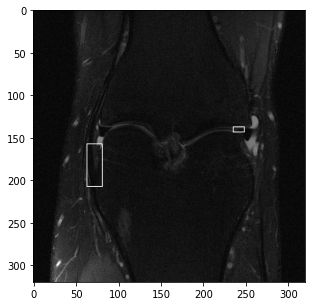

In [68]:
# Display an imageslice with annotations
arrimg = np.squeeze(img_data[slice_choice,:,:])
image_2d_scaled = (np.maximum(arrimg,0) / arrimg.max()) * 255.0
image_2d_scaled = Image.fromarray(np.uint8(image_2d_scaled))
annotated_img = plot_bounding_box(image_2d_scaled, labels_for_slice)
plt.figure(figsize = (5,5))
plt.imshow(annotated_img,'gray')
plt.show()

In [69]:
annotatedSliceDataset_Flip = fastmri.data.mri_data.AnnotatedSliceDataset(file_path,"multicoil","knee","all", annotation_version="640500fb")

In [70]:
slice_choice = 21
df = pd.DataFrame(annotatedSliceDataset_Flip.annotated_examples)
labels_for_slice_test = df[(df[0] == file_name) & (df[1] == slice_choice)][2].values.tolist()
labels_for_slice_test

[{'padding_left': 0,
  'padding_right': 370,
  'encoding_size': (640, 370, 1),
  'recon_size': (320, 320, 1),
  'annotation': {'fname': 'file1000638',
   'slice': 21,
   'study_level': 'No',
   'x': 235,
   'y': 176,
   'width': 13,
   'height': 6,
   'label': 'Meniscus Tear'}},
 {'padding_left': 0,
  'padding_right': 370,
  'encoding_size': (640, 370, 1),
  'recon_size': (320, 320, 1),
  'annotation': {'fname': 'file1000638',
   'slice': 21,
   'study_level': 'No',
   'x': 63,
   'y': 112,
   'width': 18,
   'height': 50,
   'label': 'Ligament - MCL Low-Mod Grade Sprain'}}]

In [71]:
img_data = hf['reconstruction_rss'][:]
img_data = img_data[:, ::-1, :] # flipped up down
img_data.shape

(36, 320, 320)

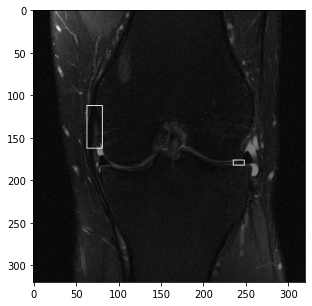

In [72]:
# Display an imageslice with annotations
arrimg = np.squeeze(img_data[slice_choice,:,:])
image_2d_scaled = (np.maximum(arrimg,0) / arrimg.max()) * 255.0
image_2d_scaled = Image.fromarray(np.uint8(image_2d_scaled))
annotated_img_flip = plot_bounding_box_flip(image_2d_scaled, labels_for_slice_test)
plt.figure(figsize = (5,5))
plt.imshow(annotated_img_flip,'gray')
plt.show()

# Compare two ways of adding bounding boxes

1. Flip up-down first and then using original annotaions to draw bounding box. Finally, flip up-down back to original. 

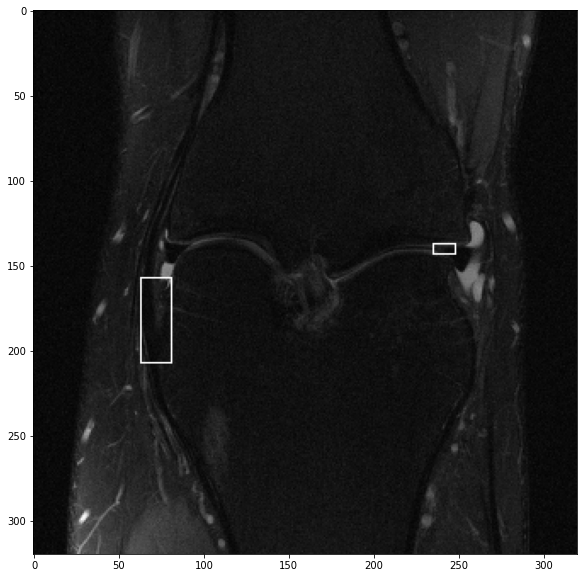

In [73]:
plt.figure(figsize = (10,10))
plt.imshow(annotated_img_flip[::-1,:],'gray')
# x = [100, 200]
# y = [144, 144]
# plt.plot(x, y, color="white", linewidth=1)

2. Use $y'=320-y-height$ to calculate bounding box location

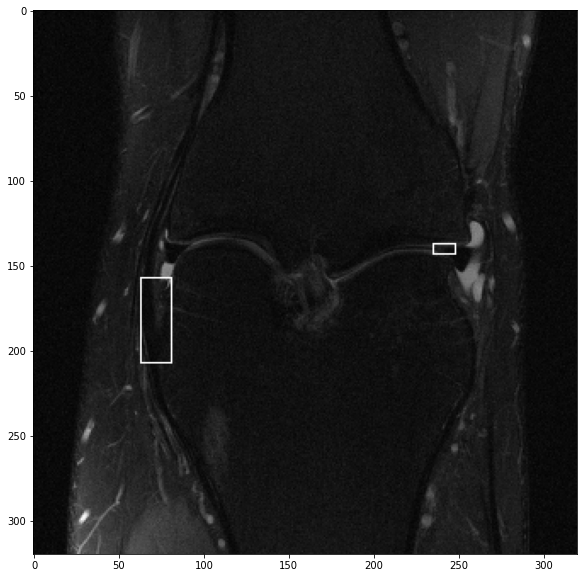

In [74]:
plt.figure(figsize = (10,10))
plt.imshow(annotated_img,'gray')
# x = [100, 200]
# y = [144, 144]
# plt.plot(x, y, color="white", linewidth=1)


# Compare in each pixel

In [75]:
gap = annotated_img_flip[::-1,:] - annotated_img
gap

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [76]:
all = 0
for i in range(len(gap)):
    if sum(gap[i]) > 0:
        print(i)
    all += sum(gap[i])
all    

0